In [1]:
import pandas as pd 

# Load the Excel file
excel_file = pd.ExcelFile('./final_exam_data.xlsx')

# Print all sheet names
print(excel_file.sheet_names)


['portfolio', 'forecasting', 'fx_carry']


In [2]:
portfolio = pd.read_excel('./final_exam_data.xlsx',sheet_name='portfolio',index_col=0)
forecasting = pd.read_excel('./final_exam_data.xlsx',sheet_name='forecasting',index_col=0)
fx_carry = pd.read_excel('./final_exam_data.xlsx',sheet_name='fx_carry',index_col=0)
fx_carry

,MXN,SOFR,MXSTR
date,,,
2018-04-03,0.054959,0.000073,0.000298
2018-04-04,0.054852,0.000069,0.000298
2018-04-05,0.055166,0.000069,0.000298
2018-04-06,0.054558,0.000069,0.000298
2018-04-09,0.054871,0.000069,0.000298
...,...,...,...
2023-11-24,0.058392,0.000211,0.000446
2023-11-27,0.058302,0.000211,0.000446
2023-11-28,0.058418,0.000211,0.000446


# Question 2 

Part 1

In [21]:
import numpy as np 
def tangency_weights(returns,dropna=True,scale_cov=1, name = 'Tangency'):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()
    tangency_weights_df = pd.DataFrame(weights, index=returns.columns, columns=[f'{name} Weights'])

    return tangency_weights_df

tan_wts = tangency_weights(portfolio)
tan_wts

,Tangency Weights
SPY,0.857595
BTC,0.141710
USO,-0.043098
TLT,-0.040488
IEF,0.167449
IYR,-0.440830
GLD,0.357662


In [30]:
def mv_portfolio_excess_returns(ex_ret, target_ret, tan_wts):
    
    mu_tilde = ex_ret.copy().mean()
    
    Sigma_adj = ex_ret.copy().cov()
    
    Sigma_inv = np.linalg.inv(Sigma_adj)
    
    N = Sigma_adj.shape[0]
    
    delta_tilde = ((np.ones(N) @ Sigma_inv @ mu_tilde)/(mu_tilde @ Sigma_inv @ mu_tilde)) * target_ret
    
    omega_star = delta_tilde * tan_wts
    
    return omega_star
    
def portfolio_returns_calc(data, weights_df): 
    return pd.DataFrame(data @ (weights_df.values)) 



mv_portfolio_excess_returns(portfolio, 0.0025, tangency_weights(portfolio))

,Tangency Weights
SPY,0.479969
BTC,0.079311
USO,-0.024120
TLT,-0.022660
IEF,0.093716
IYR,-0.246719
GLD,0.200172


In [46]:
# GMV
def gmv_weights(returns, annualization_factor):
    ones = np.ones(returns.columns.shape)
    
    cov = returns.cov()* annualization_factor
    cov_inv = np.linalg.inv(cov)
    scaling = 1/(np.transpose(ones) @ cov_inv @ ones)
    gmv_tot = scaling * cov_inv @ ones
    gmv_weights_df = pd.DataFrame(gmv_tot, index=returns.columns, columns=['GMV Weights'])
    
    return gmv_weights_df
gmv = gmv_weights(portfolio, 52)
gmv

,GMV Weights
SPY,0.092076
BTC,-0.001009
USO,0.002750
TLT,-0.476953
IEF,1.427028
IYR,-0.041140
GLD,-0.002752


In [103]:
annualization_factor = 52 
def mv_portfolio(target_ret, returns: pd.DataFrame):
    
    mu_tan = returns.mean() @ tangency_weights(returns,  1)
    mu_gmv = returns.mean() @ gmv_weights(returns, annualization_factor)
    
    delta = (target_ret - mu_gmv[0])/(mu_tan[0] - mu_gmv[0])
    mv_weights = (delta * tangency_weights(returns,  1)).values + ((1-delta)*gmv_weights(returns, annualization_factor)).values
    
    MV = pd.DataFrame(index = returns.columns, data = mv_weights, columns = ['MV Weights'] )
    MV['tangency weights'] =  tangency_weights(returns,  1).values
    MV['GMV weights'] =   gmv_weights(returns, annualization_factor).values

    return MV

mv_portfolio(0.0025, portfolio)

,MV Weights,tangency weights,GMV weights
SPY,0.498982,0.857595,0.092076
BTC,0.074852,0.141710,-0.001009
USO,-0.021620,-0.043098,0.002750
TLT,-0.244953,-0.040488,-0.476953
IEF,0.757509,0.167449,1.427028
IYR,-0.253592,-0.440830,-0.041140
GLD,0.188823,0.357662,-0.002752


Conceptual: Part 1 is benchmarked against the risk-free rate, while Part 2 focuses purely on total returns and risk minimization.
Mathematical: The tangency portfolio and MV portfolio in Part 1 use excess returns, while GMV and MV portfolios in Part 2 use total returns.

In [73]:
def equal_weights(returns): 
    return pd.DataFrame(index = returns.columns, data = 1/len(returns.columns), columns = ['EWP Weights'])


In [87]:
portfolio_copy = portfolio.drop(columns=['BTC'])
is_data = portfolio_copy.loc[:'2021']

MU_WEEKLY_TARGET = 0.0025

tangency_weights_df = tangency_weights(is_data)

adjustment_factor = MU_WEEKLY_TARGET / (is_data.mean() @ tangency_weights_df.values)
tangency_weights_df *= adjustment_factor
tangency_weights_df


,Tangency Weights
SPY,0.708230
USO,-0.034790
TLT,-0.279598
IEF,1.712950
IYR,-0.252887
GLD,0.023858


In [109]:
def performance_summary(return_data, quantile, annualization_factor):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().apply(lambda x: x*annualization_factor)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization_factor))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats[f'VaR ({quantile})'] = return_data.quantile(quantile, axis = 0)
    summary_stats[f'CVaR ({quantile})'] = return_data[return_data <= return_data.quantile(quantile, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [110]:
# OOS period
oos_data = portfolio_copy.loc['2022':'2023']
returns = oos_data @ tangency_weights_df.values

performance_summary(returns, 0.05, 52)[['Mean', 'Volatility', 'Sharpe Ratio']]

NameError: name 'portfolio_copy' is not defined

In [82]:
ewp_weights_df = equal_weights(is_data)
adjustment_factor = MU_WEEKLY_TARGET / (is_data.mean() @ ewp_weights_df.values)
ewp_weights_df *= adjustment_factor
ewp_weights_df

,EWP Weights
SPY,0.242376
USO,0.242376
TLT,0.242376
IEF,0.242376
IYR,0.242376
GLD,0.242376


In [95]:
returns = oos_data @ ewp_weights_df.values
performance_summary(returns, 0.05, 52)[['Mean', 'Volatility', 'Sharpe Ratio']]


,Mean,Volatility,Sharpe Ratio
0,-0.036569,0.183591,-0.199185


The tangency weighted portfolio has a more negative sharpe ratio and performs worse than the ewp portfolio

# Q3

In [29]:
annualization_factor = 12 

import statsmodels.api as sm
def time_series_regression(portfolio, factors, annualization_factor, FF3F = False, resid = False):
    
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * annualization_factor
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_report.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(annualization_factor) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = annualization_factor * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(annualization_factor))

        if resid:
            bm_residuals[portf] = res.resid
            
            
        
    if resid:
        return bm_residuals
        
    return ff_report

In [ ]:
time_series_regression(y, x, annualization_factor)

In [30]:
import statsmodels.api as sm 
y = forecasting['USO']
x = forecasting[['Tnote rate change', 'Tnote rate']].shift()
x = sm.add_constant(x)  # Add constant term (intercept)

data = pd.concat([y, x], axis=1).dropna()
y = data['USO']
x = data[['const', 'Tnote rate change', 'Tnote rate']]

model = sm.OLS(y, x).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    USO   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.475
Date:                Fri, 29 Nov 2024   Prob (F-statistic):             0.0871
Time:                        09:01:40   Log-Likelihood:                 151.77
No. Observations:                 174   AIC:                            -297.5
Df Residuals:                     171   BIC:                            -288.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0201      0.024      0.849      0.397      -0.027       0.067
Tnote rate change     0.0741      0.034      2.156      0.032       0.006       0.142
Tnote rate           -0.0096      0.009     -1.014      0.312      -0.028       0.009
==============================================================================
Omnibus:                       53.648   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.333
Skew:                          -1.071   Prob(JB):                     1.76e-52
Kurtosis:                       8.318   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
alpha = model.params['const']
beta_1 = model.params['Tnote rate change']
beta_2 = model.params['Tnote rate']

forecasted_returns = alpha + beta_1 * forecasting['Tnote rate change'].shift() + beta_2 * forecasting['Tnote rate']
forecasted_returns = forecasted_returns.dropna()
forecasted_returns

date
2009-06-30    0.011664
2009-07-31   -0.009085
2009-08-31   -0.014053
2009-09-30   -0.018930
2009-10-31   -0.019299
                ...   
2023-07-31   -0.004283
2023-08-31   -0.008676
2023-09-30   -0.013714
2023-10-31    0.009022
2023-11-30    0.001618
Length: 174, dtype: float64

In [134]:
er = forecasted_returns.mean()*annualization_factor
vol = forecasted_returns.std() *np.sqrt(annualization_factor)
    
wealth_index = 1000*(1+forecasted_returns).cumprod()
previous_peaks = wealth_index.cummax()
drawdowns = (wealth_index - previous_peaks)/previous_peaks

er, vol, drawdowns.min()

(-0.10177964796155718, 0.12318402954155545, -0.4285165391761875)

In [135]:
er = y.mean()*annualization_factor
vol = y.std() *np.sqrt(annualization_factor)
    
wealth_index = 1000*(1+y).cumprod()
previous_peaks = wealth_index.cummax()
drawdowns = (wealth_index - previous_peaks)/previous_peaks

er, vol, drawdowns.min()

(-0.09947476816682158, 0.7420210913526355, -0.9470653372285206)

In [147]:
# optimal hedge ratio -> regres 
y = forecasted_returns
x = forecasting['USO'][1:]
model = sm.OLS(y, sm.add_constant(x)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.678
Date:                Thu, 28 Nov 2024   Prob (F-statistic):              0.104
Time:                        19:51:37   Log-Likelihood:                 463.08
No. Observations:                 174   AIC:                            -922.2
Df Residuals:                     172   BIC:                            -915.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.488      0.139      -0.004       0.001
USO            0.0206      0.013      1.636      0.104      -0.004       0.045
==============================================================================
Omnibus:                        2.281   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.320   Jarque-Bera (JB):                2.283
Skew:                          -0.273   Prob(JB):                        0.319
Kurtosis:                       2.873   Cond. No.                         9.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Hedge ratio = 0.0206. Therefore, just long 2.06% of USO on the portfolio. 


In [151]:
((forecasting['USO'][1:] * model.params['USO'] +  model.params['const']) + forecasted_returns).mean()

-0.003914601844675276

In [53]:
def OOS_strat(df, factors, start):
    y = df
    X = sm.add_constant(factors)

    forecast_err, null_err,oos_predictions,null_predictions = [], [],[],[]

    for i,j in enumerate(df.index):
        if i >= start:
            currX = X.iloc[:i]
            currY = y.iloc[:i]
            reg = sm.OLS(currY, currX, missing = 'drop').fit()
            null_forecast = currY.mean()
            reg_predict = reg.predict(X.iloc[[i]])
            actual = y.iloc[[i]]
            oos_predictions.append(reg_predict.T)
            null_predictions.append(pd.DataFrame([[reg_predict.index[0]]], columns = ['date'], index = [null_forecast]))
            forecast_err.append(reg_predict.values - actual)
            
            null_err.append(null_forecast - actual)
            
    RSS = (np.array(forecast_err)**2).sum()
    TSS = (np.array(null_err)**2).sum()
    predictions_df = pd.concat(oos_predictions).T.drop_duplicates()
    null_predictions_df = pd.concat(null_predictions).reset_index().set_index('date')
    null_predictions_df = null_predictions_df.rename(columns = {'index':'Baseline Forecasts'})
    
    return ((1 - RSS/TSS),reg,predictions_df,null_predictions_df)

In [36]:
forecasting.loc[:'2017'].shape[0]

104

In [54]:
factor = forecasting[['Tnote rate', 'Tnote rate change']].shift(1) 
fund = forecasting['USO']
OOS_r2, OOS_reg_params, OOS_forecasts, null_predictions_df = OOS_strat(fund,factor, forecasting.loc[:'2017'].shape[0])
OOS_forecasts.head(), OOS_forecasts.tail()

(date
 2018-01-31   -0.007559
 2018-02-28    0.002248
 2018-03-31   -0.005113
 2018-04-30   -0.011960
 2018-05-31   -0.002330
 dtype: float64,
 date
 2023-07-31   -0.006231
 2023-08-31   -0.006372
 2023-09-30   -0.007037
 2023-10-31    0.019210
 2023-11-30   -0.002345
 dtype: float64)

In [56]:
# baseline forecast -> mean of USO up to the point the forecast is made 
null_predictions_df.head()

,Baseline Forecasts
date,
2018-01-31,-0.004810
2018-02-28,-0.003995
2018-03-31,-0.004400
2018-04-30,-0.003815
2018-05-31,-0.003278


In [57]:
OOS_r2

-0.0044913307399883085

Not very effective. 

In [64]:
OOS_forecasts = OOS_forecasts.reset_index().rename(columns = {0: 'Forecasted'})
null_predictions_df = null_predictions_df.reset_index()


,date,Forecasted,Baseline Forecasts
0,2018-01-31,-0.007559,-0.004810
1,2018-02-28,0.002248,-0.003995
2,2018-03-31,-0.005113,-0.004400
3,2018-04-30,-0.011960,-0.003815
4,2018-05-31,-0.002330,-0.003278
...,...,...,...
66,2023-07-31,-0.006231,-0.001238
67,2023-08-31,-0.006372,-0.000345
68,2023-09-30,-0.007037,-0.000193
69,2023-10-31,0.019210,0.000255


In [70]:
uso = forecasting.loc['2018':, 'USO'].reset_index()
combined_df = pd.merge(OOS_forecasts, uso, on = 'date')
combined_df.set_index('date').corr()


,Forecasted,USO
Forecasted,1.000000,0.031923
USO,0.031923,1.000000


In [100]:
# traded strategy 
traded_strat = OOS_forecasts.set_index('date') * 50 + 0.5
performance_summary(traded_strat, 0.05, 12)[['Mean', 'Volatility', 'Max Drawdown']]
returns = traded_strat['Forecasted'].values *  uso['USO']
returns.mean()

0.005297200973195491

In [107]:
returns = (OOS_forecasts['Forecasted'] * 50 + 0.5) *  uso['USO']
returns

0     0.009859
1    -0.028779
2     0.014222
3    -0.005315
4    -0.006948
        ...   
66    0.028528
67    0.004685
68    0.011448
69   -0.105482
70   -0.012755
Length: 71, dtype: float64

In [112]:
returns.mean() * 12, returns.std() * 12

(0.0635664116783459, 1.6594978476427986)

In [113]:
uso['USO'].mean() * 12, uso['USO'].std() * 12

(0.07415155037442853, 1.558480079396587)

In [115]:
def get_max_dd(return_data): 
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    return drawdowns.min()
get_max_dd(uso['USO']), get_max_dd(returns)

(-0.8460051524219763, -0.8189743416160853)

# FX

In [3]:
fx_carry = pd.read_excel('./final_exam_data.xlsx',sheet_name='fx_carry',index_col=0)

In [4]:
risk_free_rates = fx_carry[['SOFR', 'MXSTR']]
mxn = fx_carry['MXN'] 


In [6]:
import numpy as np 
for col in risk_free_rates.columns:
    risk_free_rates[col] = fx_carry[col]
    risk_free_rates['log_'+col] = np.log(1+fx_carry[col])
risk_free_rates

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_1732/582841821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_free_rates[col] = fx_carry[col]


,SOFR,MXSTR,log_SOFR,log_MXSTR
date,,,,
2018-04-03,0.000073,0.000298,0.000073,0.000298
2018-04-04,0.000069,0.000298,0.000069,0.000298
2018-04-05,0.000069,0.000298,0.000069,0.000298
2018-04-06,0.000069,0.000298,0.000069,0.000298
2018-04-09,0.000069,0.000298,0.000069,0.000298
...,...,...,...,...
2023-11-24,0.000211,0.000446,0.000211,0.000446
2023-11-27,0.000211,0.000446,0.000211,0.000446
2023-11-28,0.000211,0.000446,0.000211,0.000446


In [7]:
risk_free_rates[['log_SOFR','log_MXSTR']].mean()

log_SOFR     0.000072
log_MXSTR    0.000291
dtype: float64

In [8]:
mxn = np.log(mxn)
mxn.mean()

-2.981326252448035

In [9]:
mxn.head()

date
2018-04-03   -2.901174
2018-04-04   -2.903123
2018-04-05   -2.897403
2018-04-06   -2.908485
2018-04-09   -2.902767
Name: MXN, dtype: float64

In [10]:
def portfolio_metrics_basic(returns: pd.DataFrame, annualization_factor: float) -> pd.DataFrame: 
    '''
    Returns Annualized ER, Vol, SR, 
    '''
    
    returns_df = pd.DataFrame(index = returns.columns) 
    mu = returns.mean() * annualization_factor
    vol = returns.std() * np.sqrt(annualization_factor)
    sr = mu / vol

    
    returns_df['Annnualized Return'] = mu.values 
    returns_df['Annnualized Vol'] = vol.values 
    returns_df['Annnualized SR'] = sr.values
    
    return returns_df



In [11]:
mxn = mxn.to_frame('mxn')
mxn.head()

,mxn
date,
2018-04-03,-2.901174
2018-04-04,-2.903123
2018-04-05,-2.897403
2018-04-06,-2.908485
2018-04-09,-2.902767


In [12]:
risk_free_rates.head()

,SOFR,MXSTR,log_SOFR,log_MXSTR
date,,,,
2018-04-03,0.000073,0.000298,0.000073,0.000298
2018-04-04,0.000069,0.000298,0.000069,0.000298
2018-04-05,0.000069,0.000298,0.000069,0.000298
2018-04-06,0.000069,0.000298,0.000069,0.000298
2018-04-09,0.000069,0.000298,0.000069,0.000298


In [13]:
fx_hldg_excess_ret = mxn['mxn'] - mxn['mxn'].shift(1) + risk_free_rates['log_MXSTR'] - risk_free_rates['log_SOFR']
portfolio_metrics_basic(fx_hldg_excess_ret.dropna().to_frame('excess_log_returns'), 252)

,Annnualized Return,Annnualized Vol,Annnualized SR
excess_log_returns,0.06671,0.128624,0.518646


<Axes: xlabel='date'>

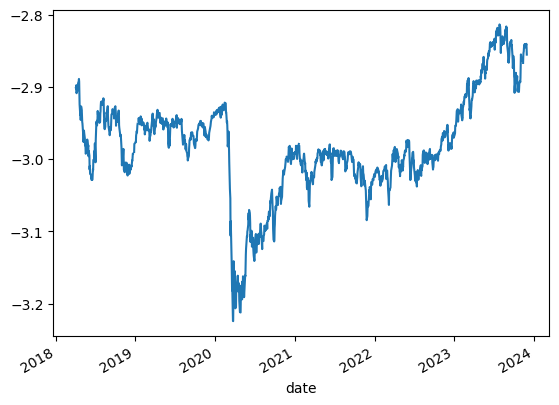

In [16]:
mxn['mxn'].plot()

Since there is excess returns of holding MXN to a USD investor, it was better to long MXN relative to USD. 
- since the excess returns were positive, it suggests that the carry trade (long MXN) was profitable and the interest rate spread was a contributing factor
- based on the exchange rate data, MXN appreciated overall relative to the US except for the sharp fall seen in 2020. 

In [25]:
factor = (risk_free_rates['log_SOFR'] - risk_free_rates['log_MXSTR']).shift(1)
strat = mxn['mxn'].diff()
import statsmodels.api as sm 
model = sm.OLS(strat, sm.add_constant(factor), missing="drop").fit()
model.params, model.rsquared

(const    0.001237
 0        5.442848
 dtype: float64,
 0.0004141588692007092)

- If UIP holds, the expected depreciation from the USD should offset any interest rate premium over the exchange rate. Therefre, beta should be 1 and alpha should be 0, with a very strong r-squared recoredd.
- if there is an increase in ir on USD relative to MXN, then the size of the factor goes up, and thus, the USD should depreciate relative to MXN.
- If MXN risk-free rates increase relative to USD risk-free rates, the forward exchange rate (F) is expected to be higher (weaker USD relative to MXN) than the spot exchange rate (S). This follows from the covered interest parity (CIP), Higher MXN rates imply a forward premium for MXN and a forward discount for USD.
- Over an annual horizon, the estimated impact of interest rates on currency returns would likely be larger. This is due to compounding effects and the longer time for interest rate differentials to influence exchange rates.k